## Issues of the paper

- Softmax factor: in paper `tau = 1.0` but in code `tau = 0.8` and `tau = 1.0` used in different places  
    - I will use `tau = 1.0`
- Social power: in paper `alpha = 0.8` but in their code sometimes `diminishingSocial = 0.77`
    - I will use multiple `alpha` values
- Variance vs standard dev: in paper, used `sigma^2` but in their code, in many instances the term "variance" was used incorrectly, and instead "standard deviation" should have been used. For example:
    - Sampling:
        - in code: `rnorm(1,mean = EnvirionemntAdol[ind,]$Mean,sd=EnvirionemntAdol[ind,]$Variance)`
        - however: `sd` argument in `rnorm` should be standard deviation        
    -  In `bayesianmeantracker`:
        - in code: `kGain <- predictions$sig[chosen] / (predictions$sig[chosen] + EnvirionemntAdol$Variance[chosen]^2)`
        - however: the error should be just `...$Variance` not `...Variance^2`    
    - Based on these, I believe the authors mistook variance and standard deviations
        - For example, in paper it's not `sigma^2` (Fig 2) as uncertainty but actually just standard deviation `sigma` of the distributions. 
        - Looking at the upper left inset in Fig 2 (claimed to have `mean = -100, sigma^2 = 80`), one could easily realize the widths of the distributions are much wider than they should be. I also plotted the 2 scenarios below, and the left seem more like the inset than the right.
    - This was the center issue of my not able to replicate the results
- Initializations of `mu0` and `var0`: oddly the variable `var0` is actually variance. However, there were still disagreements between code and paper.
    - `mu0`: in code, some places used 0.0, but paper said 100.0
    - `var0`: in code sometimes 5.0 but paper said 40.0
    - I will use `mu0 = 100.0` and `var0 = 40.0`
- Error "constants" `epsilon_j` to calculate kalman gain, I call this `var_error`. There are 3 variations of this in the code:
    1. Either just a constant 360
    2. Or just a constant 3600
    3. Or used specific variance of the task, i.e. `EnvirionemntAdol$Variance[chosen]^2`


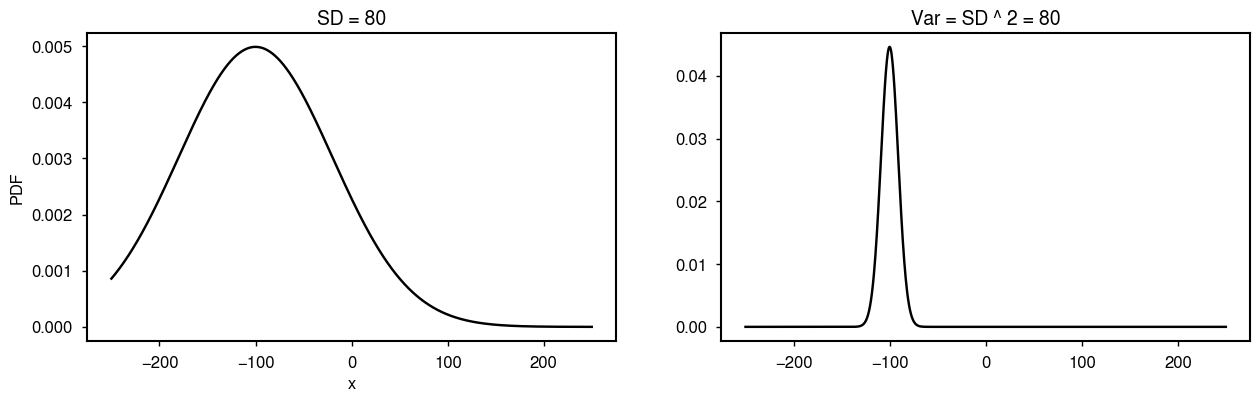

In [6]:
from scipy.stats import norm as scinorm
import matplotlib.pyplot as plt
x = np.linspace(-250,250, 1000)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(x, scinorm(loc=-100, scale=80).pdf(x), 'k-')

plt.title('SD = 80') 
plt.xlabel('x') 
plt.ylabel('PDF')

plt.subplot(122)
plt.plot(x, scinorm(loc=-100, scale=np.sqrt(80)).pdf(x), 'k-')
plt.title('Var = SD ^ 2 = 80')
plt.show()

## Replication attempts

### Startup

In [7]:
import os
if "notebooks" in os.getcwd(): os.chdir('..')

In [8]:
import pandas as pd
import numpy as np
import xarray as xr
import numpy.random as npr

import copy
from itertools import product as iterprod
import time
from tqdm.notebook import tqdm
from pathlib import Path

import socialbandit as sb


In [9]:
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams, font_manager

rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')

# use one of the available styles 
plt.style.use('seaborn-notebook')

# further customization
rcParams['font.family'] = 'FreeSans'
rcParams['font.size'] = 12

rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.linewidth'] = 1.5

rcParams['mathtext.fontset'] = 'cm' 
rcParams['mathtext.rm'] = 'serif'


### Experiment-specific functions and classes

In [10]:
def is_prevchoice_diff(A_prev, A_curr):
    # A_*: binary matrices of size "num_tasks x num_agents"
    # A_prev could also be cumulative previous A
    return np.sum(A_prev * A_curr, axis=0) < 1.0
    
def get_task_choices(A):
    inds = np.where(A > 0)
    return inds[0][np.argsort(inds[1])]

def get_task_rewards(Y):
    return Y.sum(axis=0)

def aggregate_rewards(rewards, condition):
    num = np.mean(condition.sum(axis=0))
    mag = np.mean(np.abs(rewards[condition])) if num > 0 else 0.0
    return dict(num=num, mag=mag)

def calculate_entropy(X):
    _, n = np.unique(X, return_counts=True)
    P = n/sum(n)
    return np.sum(-P * np.log2(P))

In [11]:
class SocialMAB_ChildDev(sb.models.SocialMultiArmedBandit):
    def __init__(self, num_agents=20, max_time=1200, social_alpha=0,
                 mu0 = 100.0, var0 = 40.0, softmax_tau = 1.0, BMT_error = 'use-tasks', 
                 agg_explore_step=50, agg_reward_step=400):
        
        social_set_fn = None
        social_learner = None
        if social_alpha > 0:
            social_set_fn = 'all2all'
            social_learner = sb.learners.SocialMassPower(alpha = social_alpha)
        social_settings = sb.social.SocialSetting(N = num_agents, social_fn=social_set_fn)
        
        task_settings = sb.tasks.ChildDevelopmentEnvironment(env_levels = 12)
        
        initializer = sb.initializers.InitializerBanditAgnostic(
            mu_fn = lambda x: mu0,
            sigma2_fn = lambda x: var0
        )
        
        action_sampler = sb.tasks.SoftmaxSampler(tau = softmax_tau)
        
        if type(BMT_error) is str:
            if BMT_error.lower() == 'use-tasks':
                bmt_var_err = task_settings
            else: 
                raise("If `BMT_error` is a string, only 'use-tasks' is accepted at this point")
        elif type(BMT_error) in [float, int]:
            bmt_var_err = BMT_error
        else:
            raise("`BMT_error` can either be a str/float/int")
        
        belief_updater  = sb.beliefs.BayesianMeanTracker(var_error = bmt_var_err)
        
        super().__init__(
            task_settings   = task_settings,
            social_settings = social_settings,
            clock           = sb.utils.ExperimentClock(T = max_time),
            initializer     = initializer,
            action_sampler  = action_sampler,
            belief_updater  = belief_updater,
            action_learner  = sb.learners.MeanGreedyExploit(),
            social_learner  = social_learner
        )
        
        self.set_state_managers()
        
        analysis_size = (max_time+1, num_agents)
        cum_choice_size = (self.num_tasks, num_agents)
        self.analysis = dict(
            params = dict(
                agg_explore_step = agg_explore_step, 
                agg_reward_step = agg_reward_step
            ),
            per_agent = dict(
                cum_choice = np.zeros(cum_choice_size),
                explore = np.zeros(analysis_size),
                choice = np.zeros(analysis_size),
                reward = np.zeros(analysis_size)
            ),
            time = dict(
                explore = range(0, max_time, agg_explore_step),
                reward = np.array(range(0, max_time, agg_reward_step)) + agg_reward_step,
            ),
            aggregate = dict(
                explore_num = [],
                unq_choices = [],
                explore_ent = [], 
                mean_reward = [],
                loss_num = [],
                loss_mag = [],
                gain_num = [],
                gain_mag = []                
            )
        )
        
    def analyze(self):
        t = self.t
        
        anly_per_agent = self.analysis['per_agent']
        anly_params = self.analysis['params']
        agg_anly = self.analysis['aggregate']
        
        anly_per_agent['explore'][t,:] = is_prevchoice_diff(anly_per_agent['cum_choice'], self.states.A)
        anly_per_agent['cum_choice'] += self.states.A
        
        anly_per_agent['choice'][t,:] = get_task_choices(self.states.A)
        anly_per_agent['reward'][t,:] = get_task_rewards(self.states.Y)
        
        agg_explore_step = anly_params['agg_explore_step']
        if t % agg_explore_step == 0 and t > 1:
            agg_anly['explore_num'].append(
                np.mean(anly_per_agent['explore'][t-agg_explore_step:t,:].sum(axis=0))        
            )
            
            choice_matrix = anly_per_agent['choice'][t-agg_explore_step:t,:]
            agg_anly['explore_ent'].append(
                np.mean([calculate_entropy(X) for X in choice_matrix.T])                
            )
            
            agg_anly['unq_choices'].append(
                np.mean([len(np.unique(X)) for X in choice_matrix.T])     
            )
            
            
        agg_reward_step = anly_params['agg_reward_step']
        if t % agg_reward_step == 0 and t > 0:
            reward_matrix = anly_per_agent['reward'][t-agg_reward_step:t]
            agg_anly['mean_reward'].append(np.mean(reward_matrix))
            agg_loss = aggregate_rewards(reward_matrix, reward_matrix < 0)
            
            agg_anly['loss_num'].append(agg_loss['num'])
            agg_anly['loss_mag'].append(agg_loss['mag'])
            
            agg_gain = aggregate_rewards(reward_matrix, reward_matrix > 0)
            
            agg_anly['gain_num'].append(agg_gain['num'])
            agg_anly['gain_mag'].append(agg_gain['mag'])
            
        if t == self.clock.T:
            for k, v in agg_anly.items():
                agg_anly[k] = np.array(v)


### Demo

In [12]:
# no social
model = SocialMAB_ChildDev(num_agents=1)
model.run(tqdm_fn = tqdm)
model.analysis['aggregate']

  0%|          | 0/1200 [00:00<?, ?it/s]

{'explore_num': array([36.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40., 35., 18.,  6.,  4.,
         4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'unq_choices': array([37., 19., 20., 20., 19., 21., 19., 17., 41., 42., 34., 25., 24.,
        23., 23., 18., 14., 13.,  8.,  6.,  5., 10.,  7.,  3.]),
 'explore_ent': array([5.06346519, 3.89617463, 3.93817194, 3.84529517, 3.57747656,
        3.89738994, 3.819849  , 3.65831344, 5.20385619, 5.30875844,
        4.72353594, 3.86366157, 3.95378632, 3.93935355, 3.65672186,
        3.33605761, 2.85908818, 2.9995377 , 2.16895329, 1.57663968,
        1.43715478, 2.2388142 , 1.32814072, 0.46708144]),
 'mean_reward': array([ 18.51077796,  57.6747366 , 101.81331654]),
 'loss_num': array([135.,  93.,  23.]),
 'loss_mag': array([30.59368557, 70.93165362, 34.39854874]),
 'gain_num': array([264., 307., 377.]),
 'gain_mag': array([ 43.69113157,  96.63367566, 110.12332424])}

In [13]:
# with social 
model = SocialMAB_ChildDev(num_agents=10,social_alpha = 0.8)
model.run(tqdm_fn = tqdm)
model.analysis['aggregate']

  0%|          | 0/1200 [00:00<?, ?it/s]

{'explore_num': array([36. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 43.3, 29.1, 10.3,
        11.6,  7.6,  2.4,  1. ,  0.2,  0.7,  0.2,  0.3,  0.3,  0.1,  0.2,
         0.4,  0.1]),
 'unq_choices': array([37. , 19.9, 20.7, 20.6, 19.6, 19.7, 18.9, 17.4, 44.3, 38. , 19.7,
        27.7, 25.5, 14.2,  9.4, 10.9, 11.3, 14.6, 13.1, 14.8, 14.4, 15.5,
        16.1, 13.8]),
 'explore_ent': array([5.05726123, 4.01562194, 4.04532629, 3.91680862, 3.75791129,
        3.77685835, 3.64934387, 3.33950134, 5.38508803, 4.87322087,
        2.86078695, 4.02803755, 4.11596353, 2.32245852, 1.42639534,
        1.73134589, 2.12758592, 2.60441073, 2.31840558, 2.58304189,
        2.52274178, 2.86854729, 2.89383721, 2.69169856]),
 'mean_reward': array([17.9528594, 59.3126956, 85.5911596]),
 'loss_num': array([131. ,  88.1,  36.9]),
 'loss_mag': array([30.64477698, 66.4645007 , 56.6789555 ]),
 'gain_num': array([268. , 311.9, 363.1]),
 'gain_mag': array([ 41.77466248,  94.84001524, 100.04934535])}

### Compare 

**Metrics**:

- `explore_num`: this was first calculated bin by bin, to see whether the `choice[t]` is different from all previous `choice[:t]`, then average every 50 bins, non-overlappingly. This was an attempt to replicate the "Exploration" measure in paper. I originally only compared `choice[t]` and `choice[t-1]` and that was not right.
- `unq_choices`: for every 50 bins, calculate how many unique choices, i.e. `len(unique(choice[t-50:t]))`
- `explore_ent`: for every 50 bins, calculate the entropy of the choice distribution, i.e. `entropy(choice[t-50:t])`
- `mean_reward`: mean reward every development phase (400 bins), disregarding signs
- reward separations every development phase
    - `loss_*` is `reward < 0` and `gain_*` is `reward > 0`
    - `*_num` is the mean number of outcomes corresponding to reward signs
    - `*_mag` is the mean magnitude of outcomes corresponding to reward signs
    
    

  0%|          | 0/3 [00:00<?, ?it/s]

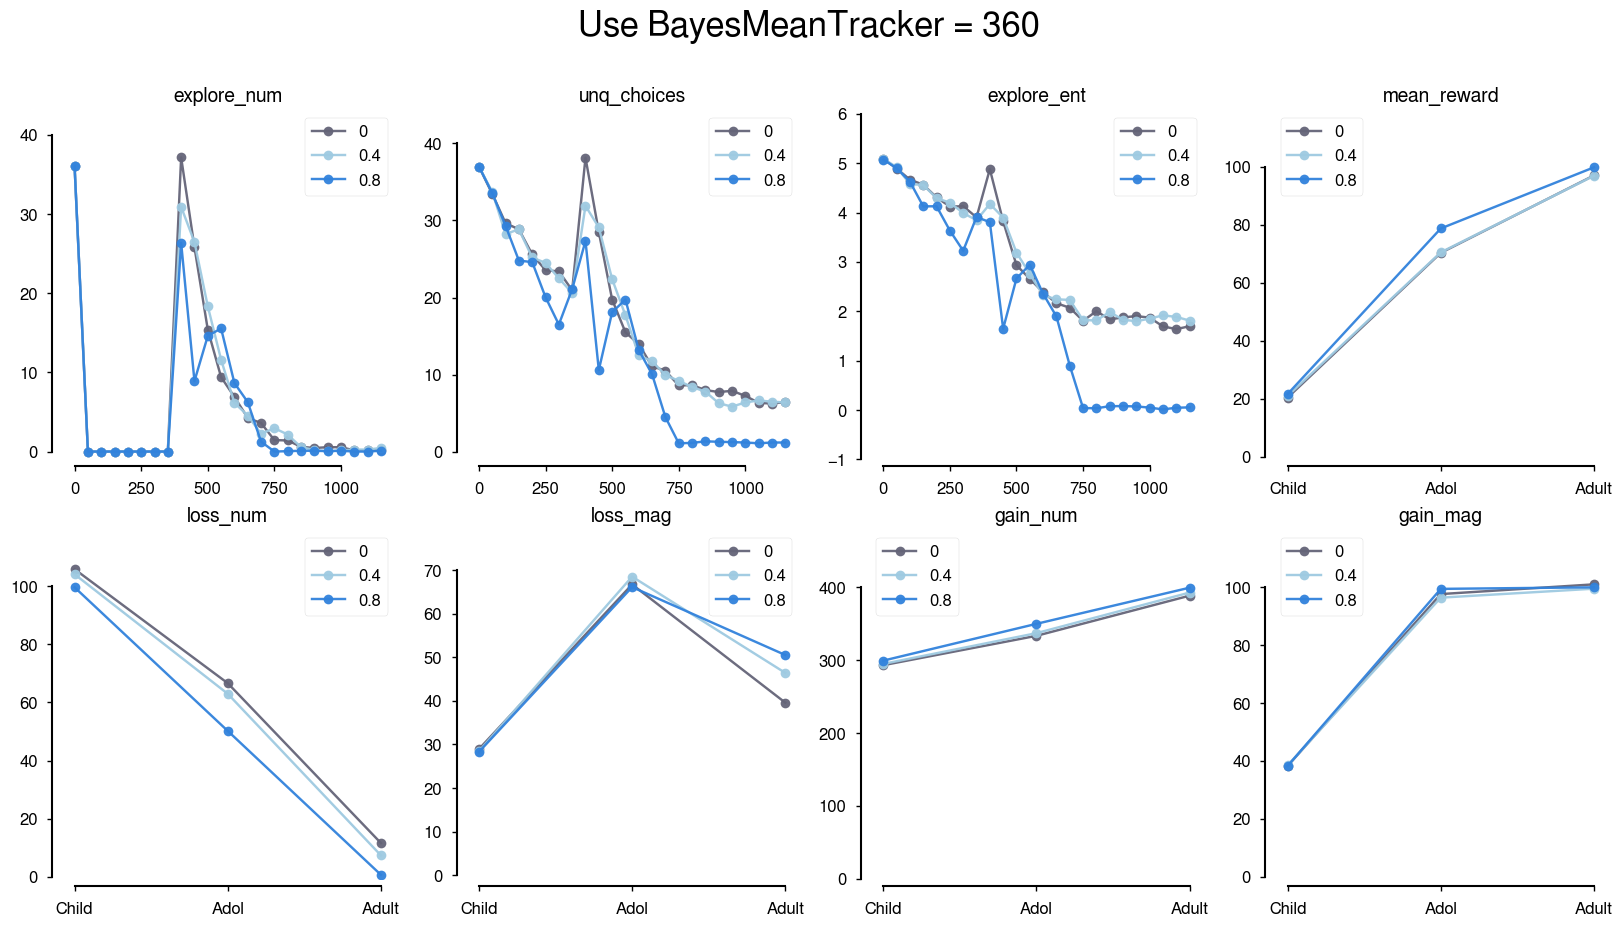

  0%|          | 0/3 [00:00<?, ?it/s]

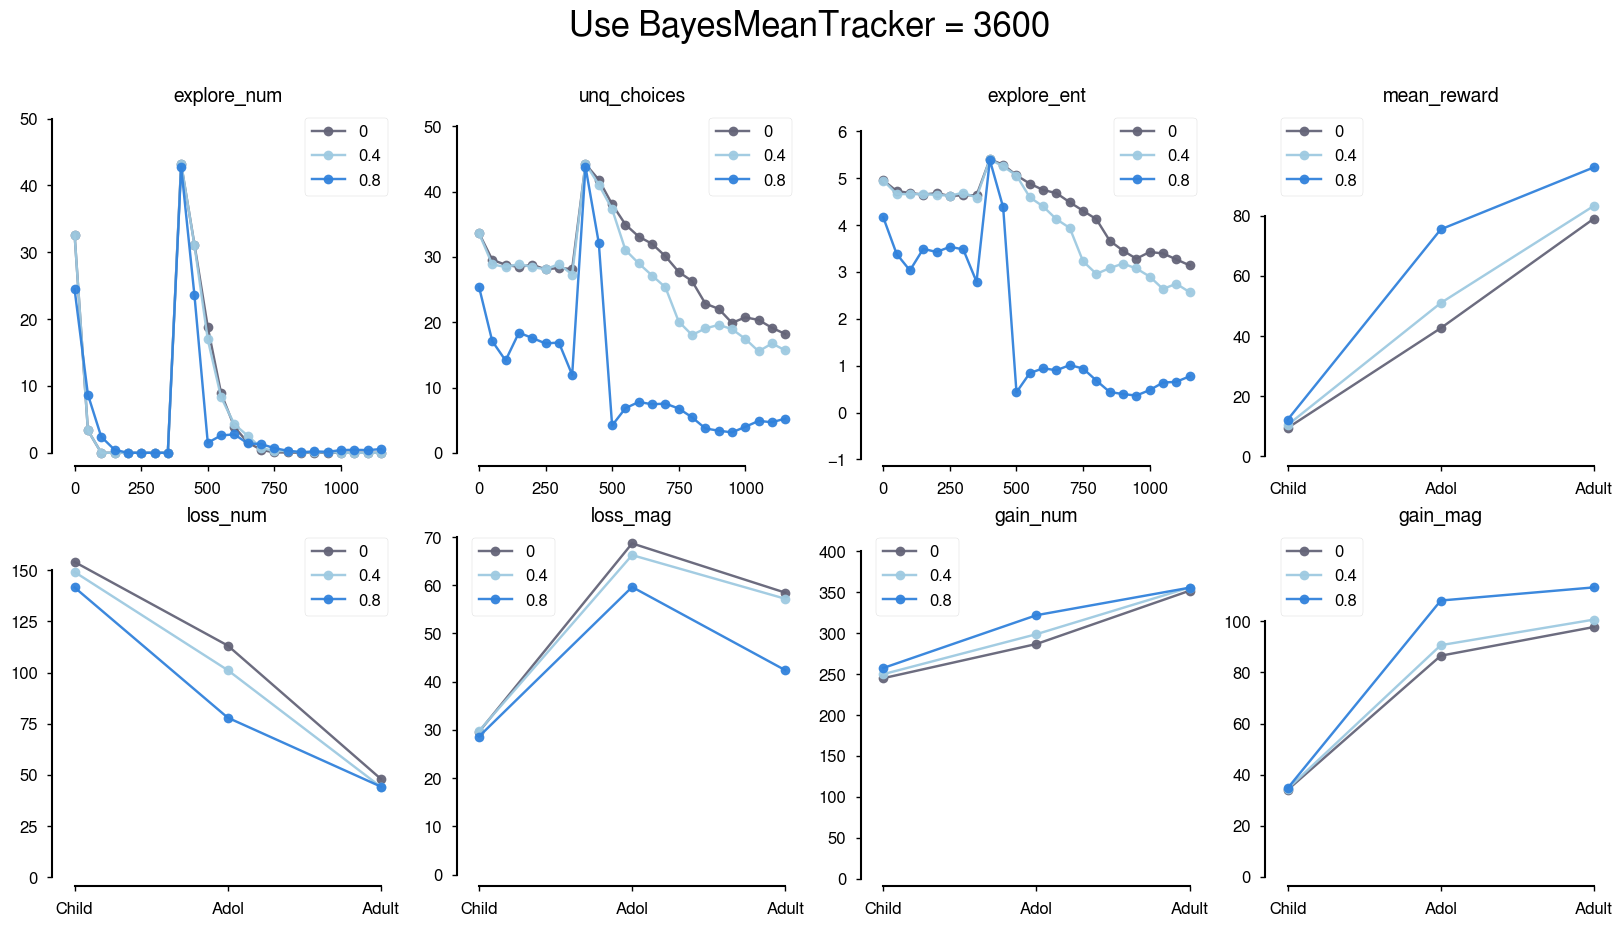

  0%|          | 0/3 [00:00<?, ?it/s]

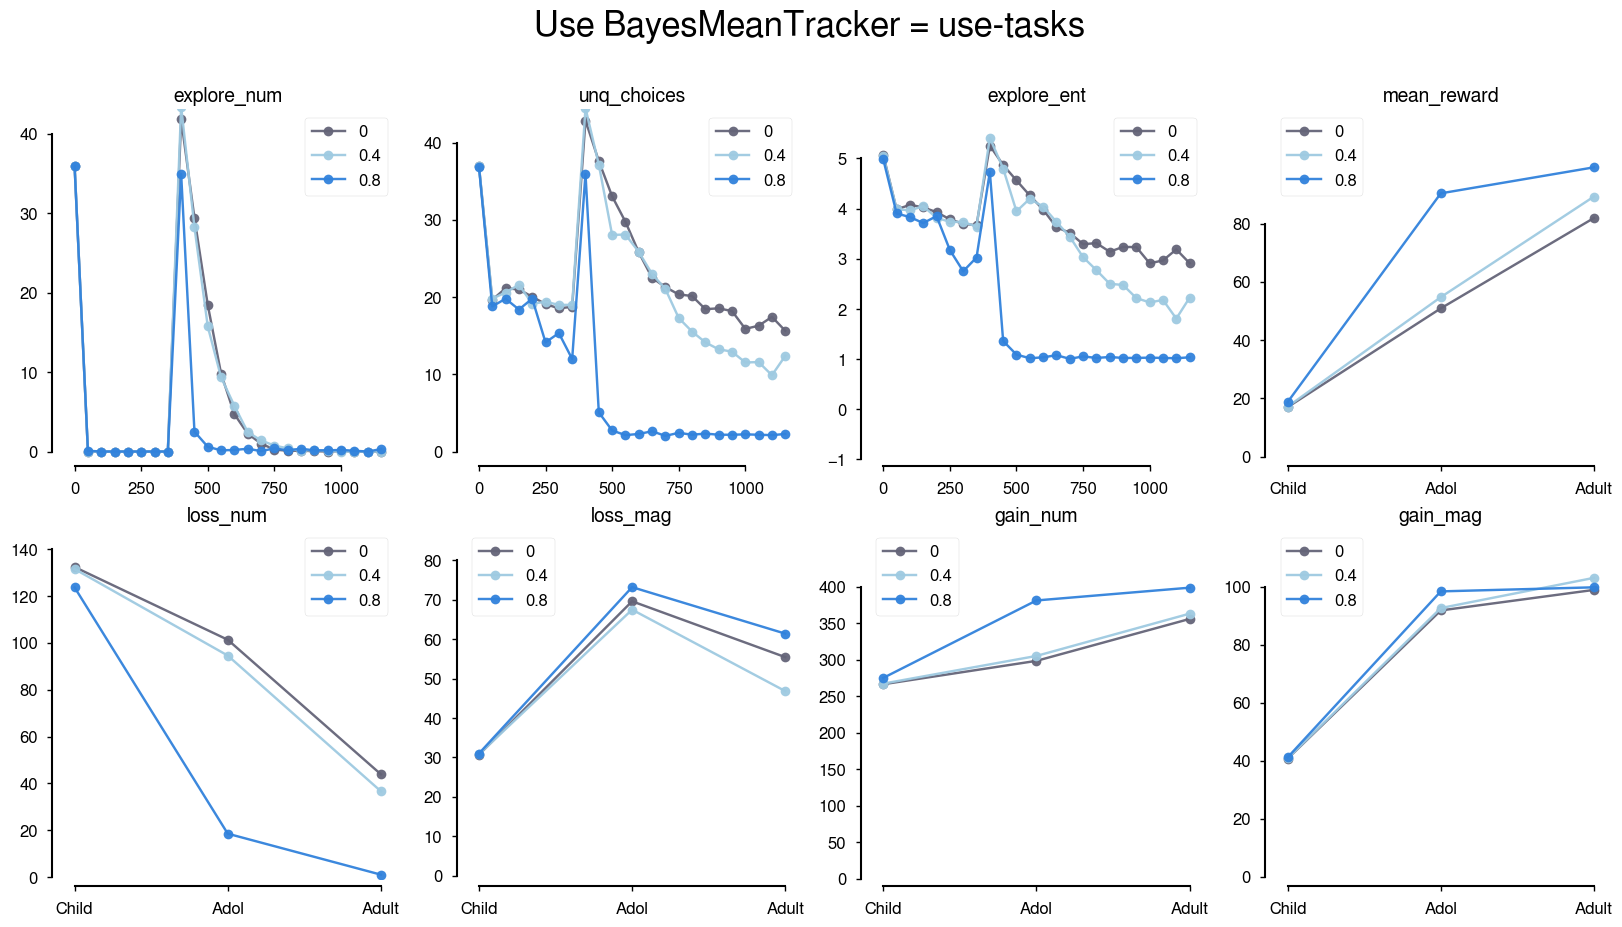

In [18]:
social_alphas = [0, 0.4, 0.8]
alpha_colors = np.array([[100,100,120],[158,202,225],[49,130,220]])/255
BMT_err_opts = [360, 3600, 'use-tasks']

for BMT_err in BMT_err_opts: 
    
    fig = plt.figure(figsize=(20,10))

    for ind_alpha, social_alpha in tqdm(list(enumerate(social_alphas))):
        model = SocialMAB_ChildDev(
            num_agents=20, 
            social_alpha = social_alpha,
            mu0 = 100.0, 
            var0 = 40.0, 
            softmax_tau = 1.0, 
            BMT_error = BMT_err
        )

        model.run(tqdm_fn = None)
        agg_anly = model.analysis['aggregate']
        agg_time = model.analysis['time']
        
        for i,(k,v) in enumerate(agg_anly.items()): 
            plt.subplot(2,4,i+1)
            t = agg_time['explore' if 'explore' in k or 'choice' in k else 'reward']
            plt.plot(t, v, '-o', label=social_alpha, alpha=0.95, c=alpha_colors[ind_alpha])

            if len(t) == 3:
                plt.xticks(ticks = t, labels=('Child', 'Adol', 'Adult'))
            plt.title(k)
            plt.legend()
            plt.ylim(-1, max(v) * 1.2)
            sns.despine(trim=True, offset=5)

    fig.suptitle('Use BayesMeanTracker = %s' %(BMT_err), fontsize=25)
    plt.show()
    